# Introduction

The purpose of this notebook is to create a **fast ice** dataset from a simulated/modelled sea ice experiment using [CICE](https://cice-consortium-cice.readthedocs.io/en/cice6.4.1/) (or [CICE github](https://github.com/CICE-Consortium/CICE)).

## Notes
1. Some basic knowledge of Python3+ and Jupyter is required
   
3. This notebook has only been tested on the HPC **gadi**. The reason for this is mainly due to the large file sizes of the modelled sea ice experiment that are output as daily-averaged history. *and* to efficiently run CICE it is best practice to do this using hundreds of CPUs at a time. Hence this notebook has been only tested on the HPC gadi. However, that being said, there is no real reason that this notebook and underlying object-oriented Python modules cannot be run on a smaller HPC or even laptop.

4. There are underlying python modules that I have written and these provide the methods/functions that perform the work of this notebook.

5. The Python modules and this notebook were developed ``xp65`` which has a well maintained *conda* environment. This notebook is intended to be run with this basic ``ARE`` configuration ``PBS -l storage=gdata/gv90+gdata/hh5+gdata/ik11+gdata/jk72`` and then ``module use /g/data/hh5/public/modules; module load conda/analysis3-25.05``. If you have a (local) virtual environment that is equivalent to the libraries of ``conda/analysis3-25.05`` then this notebook should work for you.

+ **NOTE 3**: If you have a local directory of CICE generated results then you should edit ``../src/JSONs/afim_cice_analysis.json`` and the dictionary therein named ``D_dict``. The module/class ``SeaIceProcessor`` assumes you have simulations stored there-under with the relative-path naming convention of daily-averaged CICE model results stored as: ``[SIM_NAME]/history/daily/iceh.YYYY-MM-DD.nc``. ``SIM_NAME``

+ **NOTE 4**: If you do not have CICE generated **and** have access to __gadi__ projects: ``gv90``, ``jk72``, and ``xp65``; then this notebook should work for you in a *test* or *evaluation* mode.

# Clone the AFIM Repository

1. You do not need to edit anything here unless you want. This will clone AFIM to your local home directory.

In [19]:
import os, importlib
from pathlib import Path
# Set the directory where to clone;
# change D_repo to the directory of your choosing
AFIM_repo  = "https://github.com/dpath2o/AFIM.git"
D_repo_loc = Path.home() / "AFIM"
# use the os.system call to clone the repo if it does not already exist
if not D_repo_loc.exists():
    os.system(f"git clone {AFIM_repo} {D_repo_loc}")
else:
    print(f"AFIM repo previously cloned at: {D_repo_loc}")

AFIM repo previously cloned at: /home/581/da1339/AFIM


In [15]:
import sys
import xarray as xr
import pandas as pd
import numpy  as np
sys.path.insert(0, '/home/581/da1339/AFIM/src/AFIM/src')
from sea_ice_toolbox  import SeaIceToolbox

## Syncing any possible changes of locally cloned ``AFIM`` repo with current kernel instance
If changes have been made to the cloned local copies of any of the AFIM classe ``sea_ice_toolbox`` or: ``sea_ice_models``, ``sea_ice_plotter``, ``sea_ice_icebergs`` or ``sea_ice_obersvations``; **while** the kernel is running, then the following cell needs to be run in order for the kernel to *aware* of those changes. Else this cell can remain collapsed.

In [36]:
import sys
import importlib

# Clear ALL related modules from memory
for name in list(sys.modules):
    if name.startswith("sea_ice_toolbox"):
        del sys.modules[name]

# Reload in dependency order
import sea_ice_plotter
import sea_ice_classification
import sea_ice_metrics
import sea_ice_observations
import sea_ice_icebergs

importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
# Re-import your superclass
from sea_ice_toolbox import SeaIceToolbox



# Define Parameters
+ Next to each parameter below is a brief description of what the parameters *controls* within any/all of the ``AFIM`` modules.
+ If running this notebook in evaluation mode then this should not need any editing
+ Please do not **enable** ``overwrite_zarr`` **unless** you are working with your own version of CICE simulation results.

For a complete list of simulation names that are currently *valid*, see [afim_cice_analysis.json dictionary ``sim_dict``](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/JSONs/afim_cice_analysis.json#L144). ``sim_dict`` keys represent the simulation names. Please feel free to try other simulation name out to test. 

```python
# ARE project you are working
project_name    = "gv90"      
# gadi user name
user_name       = "da1339" 
# unique name of CICE generated results; for a complete list see
sim_name        = "gi-mid"
# sea ice speed threshold; values below which will be considered fast ice -- values should be reasonable for fast ice :-) 
ispd_thresh     = 5e-4 
# sea ice speed re-gridding scheme; requires lengthy explanation; see method documenation 
ispd_types      = ["ispd_BT"]
# "FI" = fast ice; "PI" = pack ice; suffix should be the same as ispd_types (i.e. "_BT" and "_BT", or "_Ta" and "_Ta", etc.) 
ice_types       = ["FI_BT"]
# date to start the processing/analysis; can be any valid date within the simulation period
start_date      = "1993-01-01"
# date to cease the processing/analysis; can be any valid date within the simulation period that is more recent than the start date
end_date        = "1993-12-31"
# enable/disable thresholding sea ice speed of daily-averaged CICE results
daily           = True
# enable/disable thresholding sea ice speed of N-day rolling-average of CICE results
rolling         = True
# days to compute the rolling average
roll_period     = 15
# whether or not to overwrite existing zarr files that may exist for the sea ice speed threshold and ispd_type
# ONLY enable if you are confident you want to change your existing results!! 
overwrite_zarr  = False
# whether or not to overwrite existing graphic files that have been generated by this workflow
overwrite_png   = False
# delete the original CICE netcdf and just keep the zarr; very handy in reducing disk storage
delete_original = False
# add your local edited version of ../src/JSONs/afim_cice_analysis.json; else load default
json_config     = None         
```

In [37]:
project_name    = "gv90"       
user_name       = "da1339"     
sim_name        = "elps-min"     
ispd_thresh     = 5e-4         
ispd_types      = ["ispd_BT"]  
ice_types       = ["FI_BT"]    
start_date      = "1993-01-01" 
end_date        = "1999-12-31" 
daily           = True         
rolling         = True         
roll_period     = 15           
overwrite_zarr  = False                                      
overwrite_png   = False        
log_file        = f"/g/data/{project_name}/{user_name}/logs/process_fast_ice/{sim_name}/{start_date}_{end_date}_{ispd_thresh}.log"
SI_tools        = SeaIceToolbox(sim_name             = sim_name,
                                dt0_str              = start_date,
                                dtN_str              = end_date,
                                ice_speed_threshold  = ispd_thresh,
                                ice_speed_type       = ispd_types,
                                ice_type             = ice_types,
                                log_file             = log_file,
                                overwrite_zarr       = overwrite_zarr,
                                save_new_figs        = True,
                                show_figs            = True,
                                overwrite_saved_figs = overwrite_png)

2025-06-13 21:25:02,025 - INFO - hemisphere initialised: SH


# Convert daily-averaged CICE NetCDF files to monthly-concatenated daily-averaged zarr files 
+ Hugely beneficial for working with thousands of large NetCDF files
+ I have found this reduces disk-usage of daily-averaged CICE NetCDF (``iceh.*.nc`` history) files by **70%**
+ This only needs to be run once after new simulation results are obtained
+ See [daily_iceh_to_monthly_zarr](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L257) for rationale

In [ ]:
SI_tools.daily_iceh_to_monthly_zarr()
SI_tools.verify_zarr_and_cleanup_netcdf(dry_run=False, delete=True)

# Fast Ice Masking (Daily and/or Rolling)
+ This is the backbone of processing workflow
+ See [process_daily_cice](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L734) and [process_rolling_cice](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L811) for each methods documentation
+ For more information on ``ispd_types`` the [method help documentation](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L448) provides some usage help, but this [classification discussion](https://github.com/dpath2o/AFIM/issues/9) provides more knowledge on the matter

In [ ]:
if daily:
    DS_daily = SI_tools.process_daily_cice(ispd_type            = ispd_types,
                                          overwrite_zarr_group = overwrite_zarr)
if rolling:
    DS_roll = SI_tools.process_rolling_cice(mean_period          = roll_period,
                                           ispd_type            = ispd_types,
                                           overwrite_zarr_group = overwrite_zarr)
print(DS_roll)

# Compute fast ice metrics
+ see [sea_ice_metrics_wrapper](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L1100) and [compute_sea_ice_metrics](https://github.com/dpath2o/AFIM/blob/bcad2e0c949f221f79e4b9dae1742452fd937d13/src/sea_ice_processor.py#L1195) for more knowledge on this method

In [24]:
for itype in ice_types:
    SI_tools.sea_ice_metrics_wrapper(ice_type       = itype,
                                     overwrite_zarr = True,
                                     overwrite_png  = True)

/g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_mets.zarr exists and not overwriting--loading
/g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_roll_mets.zarr exists and not overwriting--loading
/g/data/gv90/da1339/afim_output/gi-nil/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr exists and not overwriting--loading
Series([], Name: area, dtype: float32)


GMTCLibError: Failed to put vector of type int32 in column 0 of dataset.

<xarray.DataArray 'FI_OBS_GRD' (nj: 540, ni: 1440)> Size: 6MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lat      (nj, ni) float64 6MB ...
    lon      (nj, ni) float64 6MB ...
Dimensions without coordinates: nj, ni


2025-06-13 10:46:49,149 - INFO - method will plot two Antarctic sectors regional dictionary
INFO:elps-min:method will plot two Antarctic sectors regional dictionary
INFO:pyogrio._io:Created 357 records
2025-06-13 10:46:50,599 - INFO - /g/data/gv90/da1339/GRAPHICAL/AFIM/observations/east_ant/FIP/1993-01-01_observations_east_ant_FIP.png already exists and not overwriting
INFO:elps-min:/g/data/gv90/da1339/GRAPHICAL/AFIM/observations/east_ant/FIP/1993-01-01_observations_east_ant_FIP.png already exists and not overwriting


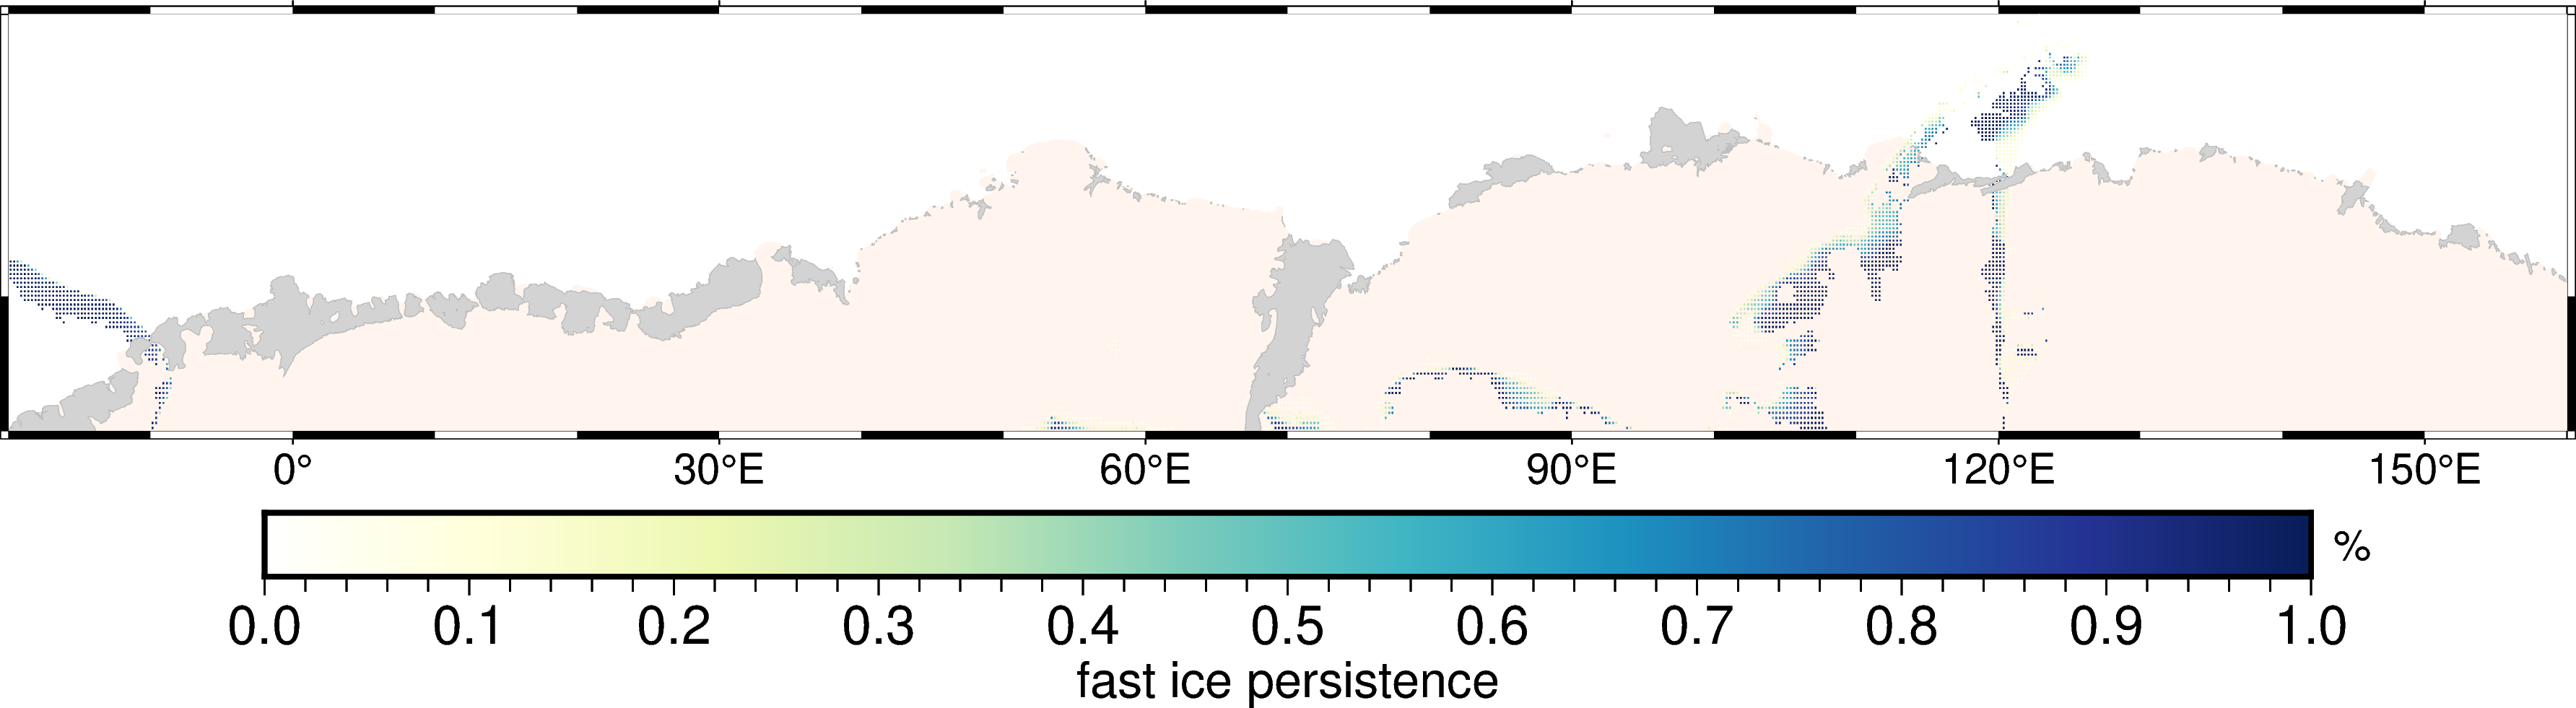

INFO:pyogrio._io:Created 357 records
2025-06-13 10:46:52,518 - INFO - /g/data/gv90/da1339/GRAPHICAL/AFIM/observations/east_ant/FIP/1993-01-01_observations_east_ant_FIP.png already exists and not overwriting
INFO:elps-min:/g/data/gv90/da1339/GRAPHICAL/AFIM/observations/east_ant/FIP/1993-01-01_observations_east_ant_FIP.png already exists and not overwriting


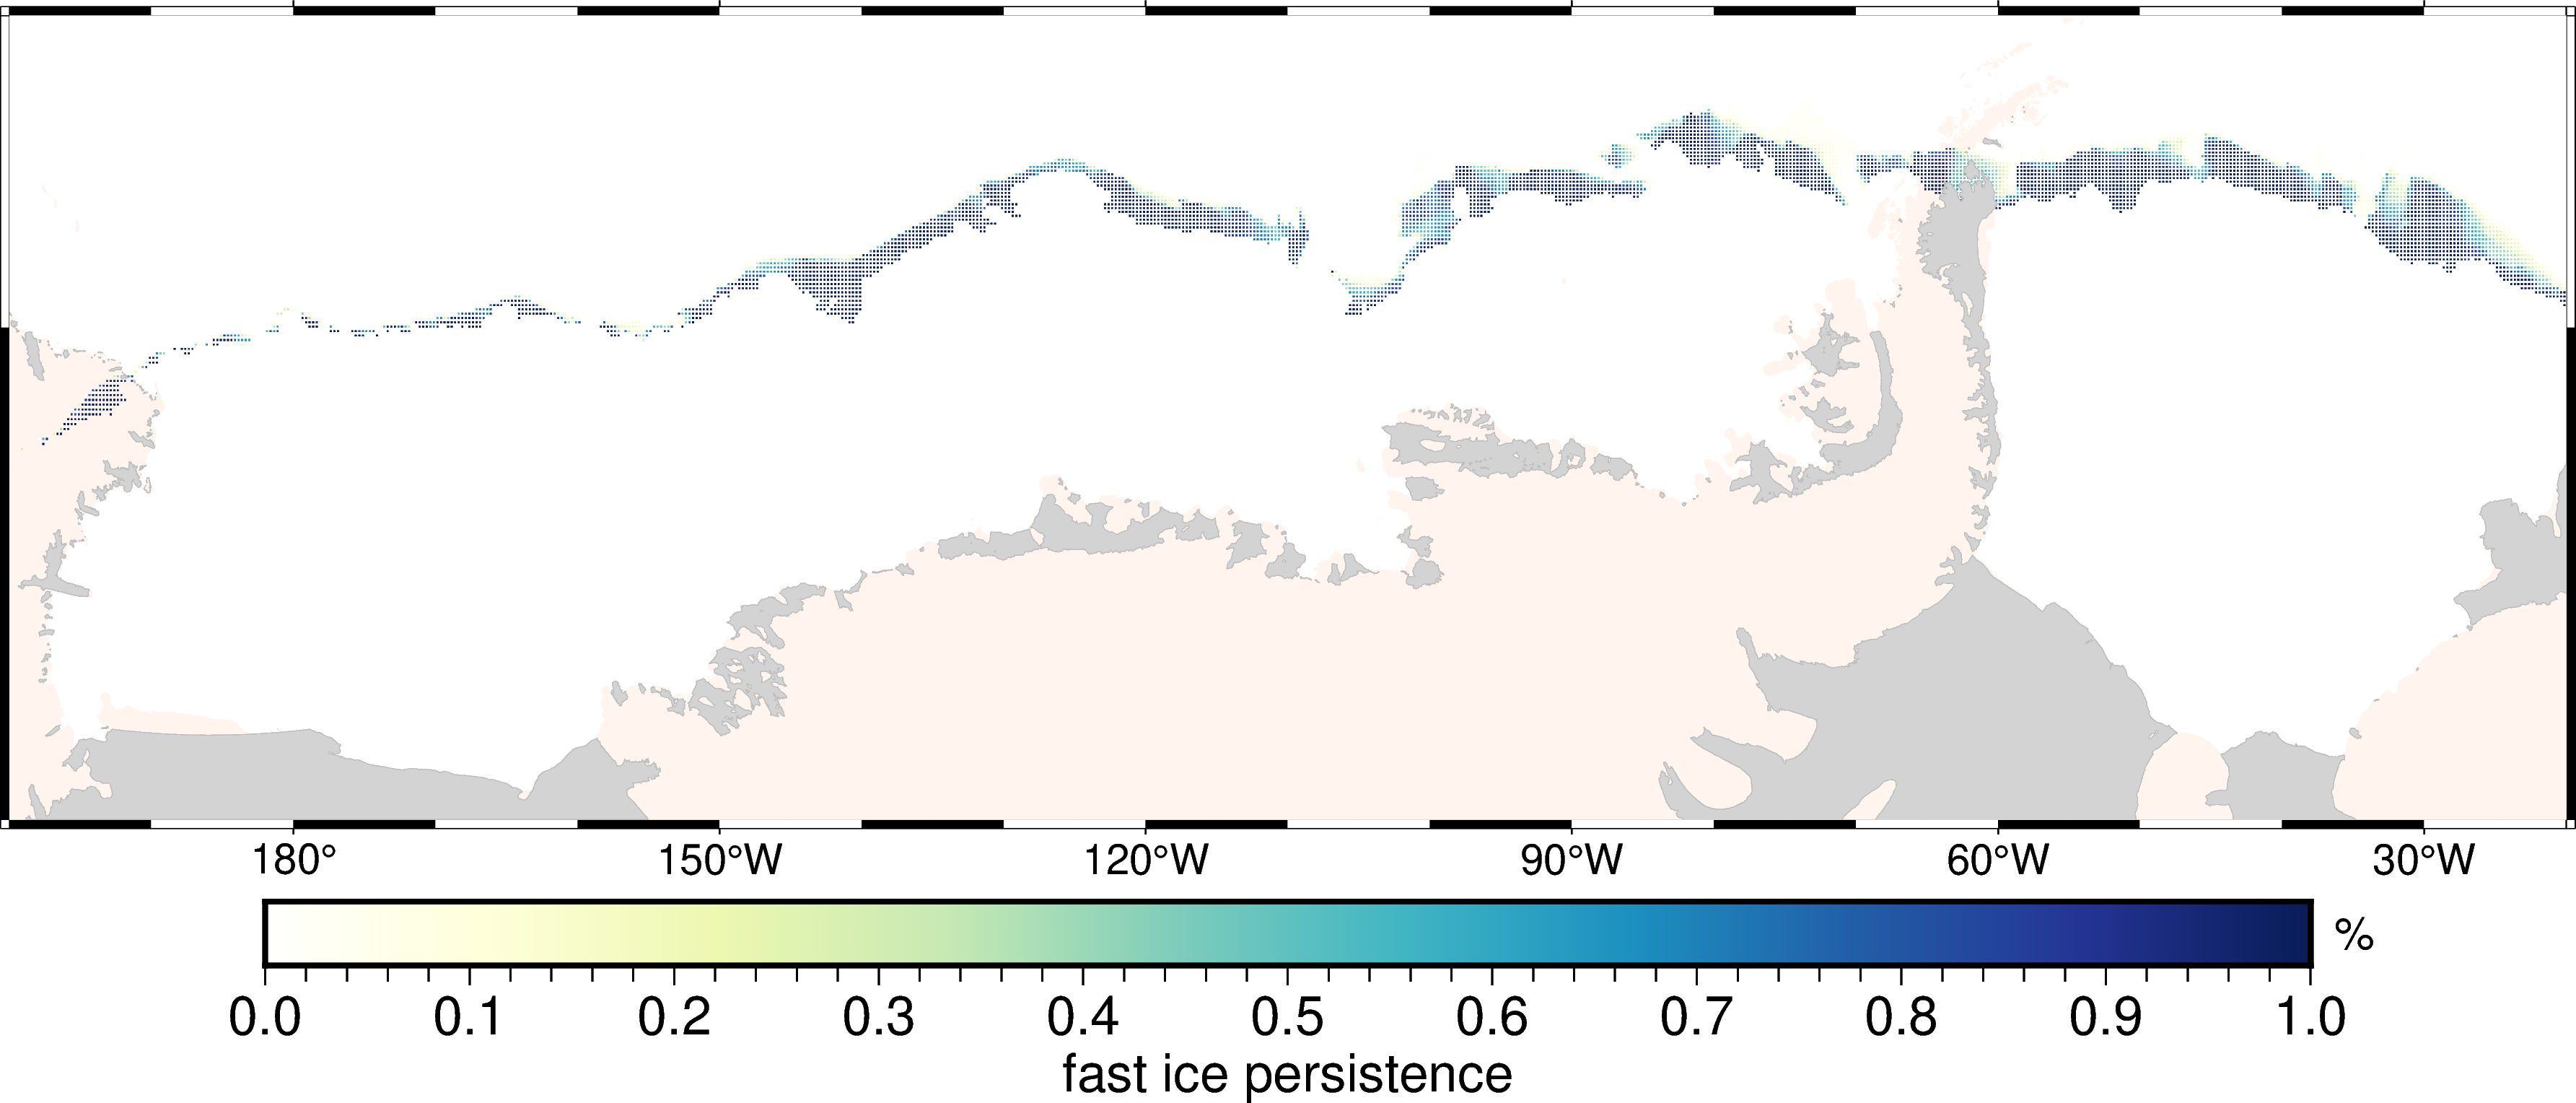

In [10]:
obs_cli   = xr.open_dataset(SI_tools.AF_FI_dict['P_AF_2020db_avg'], engine="zarr").isel(nj=SI_tools.hemisphere_dict['nj_slice'])
obs_FIP   = obs_cli['FI_OBS_GRD'].sum(dim='t_doy') / len(obs_cli['doy'])
print(obs_FIP)
sim_mets  = xr.open_dataset(Path(SI_tools.D_zarr,"ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr"), engine="zarr")
FIP_diff  = obs_FIP - sim_mets['FIP']
#print(FIP_diff)
#FIP_diff.isel(nj=slice(0,200)).plot(figsize=(30,10))
af2020_df = pd.read_csv(SI_tools.AF_FI_dict['P_AF2020_cli_csv'])
obs_FIA   = SI_tools.interpolate_obs_fia(af2020_df)
# sim_FIA   = sim_mets['FIA']
# dt        = pd.to_datetime(sim_FIA["time"].values)
# area      = sim_FIA.values
# df        = pd.DataFrame({"area": area}, index=dt)
# df["doy"] = df.index.dayofyear
# df["year"]= df.index.year
# df        = df[df["year"] > df["year"].min()]
# grouped   = df.groupby("doy")["area"]
# area_mean = grouped.mean()
# FIA_diff  = obs_FIA - area_mean
# SI_tools.plot_FIA_FIP_faceted({'FI_BT_bool' : sim_mets['FIA']}, FIP_diff,
#                               plot_GI        = True,
#                               GI_fill_color  = 'black',
#                               GI_sq_size     = 0.2,
#                               diff_plot      = True,
#                               FIA_ylim       = (-150, 150),
#                               cmap           = "cmocean/balance",
#                               series         = [-1,1],
#                               cbar_frame     = ["x+lFast Ice Persistence Difference (obsverations - simulation)", "y+l1/100"])
SI_tools.pygmt_map_plot_one_var(obs_FIP, 'FIP',
                                sim_name       = 'observations',
                                plot_regions   = 2,
                                var_sq_size    = 0.025,
                                lon_coord_name = 'lon',
                               lat_coord_name = 'lat')

In [11]:
D_obs   = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'])
P_orgs  = sorted(D_obs.glob("FastIce_70_*.nc"))
FI_obs  = xr.open_mfdataset(P_orgs, engine='netcdf4')

In [ ]:
from pyproj import CRS, Transformer
P_weights        = SI_tools.AF_FI_dict["AF_reG_weights"]
reuse_weights    = os.path.exists(P_weights)
# SI_tools.logger.info("loading FI observations with xarray mfdataset")
# SI_tools.logger.info(f"loading these files:\n{P_orgs}")
# FI_obs           = xr.open_mfdataset(P_orgs, engine='netcdf4')
SI_tools.logger.info("masking FI observations for values greater than 4")
mask             = (FI_obs['Fast_Ice_Time_series'] >= 4).compute()
FI_OBS           = xr.where( FI_obs['Fast_Ice_Time_series'] >= 4, 1.0, np.nan)
SI_tools.logger.info("define model grid")
G_t              = SI_tools.define_cice_grid( grid_type='t' , mask=False , build_grid_corners=False )
SI_tools.logger.info("convert 'AF_FI_OBS_2020db' Cartesian coordinates to spherical coordindates")
crs_obs          = CRS.from_epsg(SI_tools.AF_FI_dict["projection_FI_obs"]) #unique to observations
crs_spherical    = CRS.from_epsg(SI_tools.AF_FI_dict["projection_wgs84"])  #spherical coordinates
transformer      = Transformer.from_crs(crs_obs, crs_spherical, always_xy=True)
X, Y             = np.meshgrid(FI_obs['x'].isel(time=0).values, FI_obs['y'].isel(time=0).values)
lon_obs, lat_obs = transformer.transform(X,Y)
da_obs           = xr.DataArray(data   = FI_OBS.isel(time=0),
                                dims   = ["nj", "ni"],
                                coords = dict(lon = (["nj", "ni"], lon_obs),
                                              lat = (["nj", "ni"], lat_obs)))

In [14]:
import xesmf as xe
SI_tools.logger.info("*** Regridding 'AF_FI_OBS_2020db' to CICE T-grid *** ")
SI_tools.logger.info(f"\tDefine regridder; reusing weights : {reuse_weights}")
reG_obs          = xe.Regridder( da_obs, G_t,
                                 method            = "bilinear",
                                 periodic          = False,
                                 ignore_degenerate = True,
                                 reuse_weights     = reuse_weights,
                                 filename          = P_weights)

2025-06-13 10:57:41,518 - INFO - *** Regridding 'AF_FI_OBS_2020db' to CICE T-grid *** 
INFO:elps-min:*** Regridding 'AF_FI_OBS_2020db' to CICE T-grid *** 
2025-06-13 10:57:41,521 - INFO - 	Define regridder; reusing weights : True
INFO:elps-min:	Define regridder; reusing weights : True


In [15]:
SI_tools.logger.info(f"\tRegridding masked observational dataset")
FI_OBS_reG        = reG_obs( FI_OBS )
FI_OBS_reG

2025-06-13 10:57:48,762 - INFO - 	Regridding masked observational dataset
INFO:elps-min:	Regridding masked observational dataset
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('Y', 'X') from data variable Fast_Ice_Time_series as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (time: 432, nj: 1080, ni: 1440)> Size: 5GB
dask.array<sum-aggregate, shape=(432, 1080, 1440), dtype=float64, chunksize=(4, 784, 938), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 2000-03-01 2000-03-16 ... 2018-02-15
  * nj       (nj) int64 9kB 0 1 2 3 4 5 6 ... 1073 1074 1075 1076 1077 1078 1079
  * ni       (ni) int64 12kB 0 1 2 3 4 5 6 ... 1434 1435 1436 1437 1438 1439
Attributes:
    regrid_method:  bilinear

In [16]:
FI                = (('t_FI_obs', 'nj', 'ni'),
                     FI_OBS_reG.values,
                     {'long_name': FI_obs['Fast_Ice_Time_series'].attrs['long_name']})
t_alt             = (('t_FI_obs'),
                     FI_obs.date_alt.values,
                     {'long_name': FI_obs.date_alt.attrs['long_name'],
                      'description': FI_obs.date_alt.attrs['description']})
t_coords          = (('t_FI_obs'),
                     FI_obs.time.values,
                     {'description': "Start date of 15- or 20-day image mosaic window.",
                      'units': "days since 2000-1-1 0:0:0"})
x_coords          = (('nj','ni'),
                     G_t['lon'].values,
                     {'long_name': 'longitude', 'units': 'degrees_east'})
y_coords          = (('nj','ni'),
                     G_t['lat'].values,
                     {'long_name': 'latitude', 'units': 'degrees_north'})
SI_tools.logger.info("converted AF2020 database for use with SeaIceProcessor")
FI_obs_reG_ds = xr.Dataset({'FI'       : FI,
                            'FI_t_alt' : t_alt },
                            coords = {'t_FI_obs' : t_coords,
                                      'lon'      : x_coords,
                                      'lat'      : y_coords})

2025-06-13 11:03:18,740 - INFO - converted AF2020 database for use with SeaIceProcessor
INFO:elps-min:converted AF2020 database for use with SeaIceProcessor


In [21]:
print(FI_obs_reG_ds)

<xarray.Dataset> Size: 5GB
Dimensions:   (t_FI_obs: 432, nj: 1080, ni: 1440)
Coordinates:
  * t_FI_obs  (t_FI_obs) datetime64[ns] 3kB 2000-03-01 2000-03-16 ... 2018-02-15
    lon       (nj, ni) float64 12MB -99.88 -99.62 -99.38 ... -100.0 -100.0
    lat       (nj, ni) float64 12MB -81.08 -81.08 -81.08 ... 65.24 65.13 65.03
Dimensions without coordinates: nj, ni
Data variables:
    FI        (t_FI_obs, nj, ni) float64 5GB nan nan nan nan ... 0.0 0.0 0.0 0.0
    FI_t_alt  (t_FI_obs) int32 2kB 20000301 20000316 ... 20180131 20180215


In [22]:
for coord in FI_obs_reG_ds.coords:
    if coord in ["t_FI_obs", "time"]:
        FI_obs_reG_ds[coord].attrs.pop("units", None)
        FI_obs_reG_ds[coord].attrs.pop("calendar", None)
FI_obs_reG_ds.to_zarr("/g/data/gv90/da1339/SeaIce/FI_obs/AF-FI-2020db_org-timestep_reG.zarr")

In [4]:
CICE_all            = SI_tools.load_iceh_zarr()

2025-06-13 11:44:04,441 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-01.zarr
2025-06-13 11:44:07,849 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-02.zarr
INFO:elps-min:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-02.zarr
2025-06-13 11:44:07,877 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-03.zarr
INFO:elps-min:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-03.zarr
2025-06-13 11:44:07,905 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-04.zarr
INFO:elps-min:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-04.zarr
2025-06-13 11:44:07,932 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-05.zarr
INFO:elps-min:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-05.zarr
2025-

In [5]:
CICE_ispds          = SI_tools.compute_ice_speed_types( CICE_all, ['ispd_BT'] )
CICE_reM            = SI_tools.reapply_landmask( CICE_ispds )
CICE_reM['ispd_BT'] = SI_tools.compute_composite_ice_speed( CICE_reM )

2025-06-13 11:44:16,329 - INFO - Computing B-grid ice speed ('ispd_B') and internal ice stress ('ists_B')
INFO:elps-min:Computing B-grid ice speed ('ispd_B') and internal ice stress ('ists_B')
2025-06-13 11:44:16,344 - INFO - Spatially-Averaging (re-griddding) ispd_B and ists_B to T-grid: CREATING ispd_Ta and ists_Ta
INFO:elps-min:Spatially-Averaging (re-griddding) ispd_B and ists_B to T-grid: CREATING ispd_Ta and ists_Ta
2025-06-13 11:45:35,961 - INFO - xESMF regrid to T-grid
INFO:elps-min:xESMF regrid to T-grid
2025-06-13 11:45:36,193 - INFO - Reusing regrid weights: /g/data/gv90/da1339/grids/weights/map_AOM2_u_to_t_0p25_bilinear_with_mask.nc
INFO:elps-min:Reusing regrid weights: /g/data/gv90/da1339/grids/weights/map_AOM2_u_to_t_0p25_bilinear_with_mask.nc
2025-06-13 11:45:42,482 - INFO - regridding variable: strairx
INFO:elps-min:regridding variable: strairx
2025-06-13 11:45:42,484 - INFO - regridding variable: strairy
INFO:elps-min:regridding variable: strairy
2025-06-13 11:45:42,48

In [ ]:
CICE_ispd_roll = SI_tools.compute_ice_speed_types(CICE_all, ['ispd_BT'], temporally_average=True, mean_period=15)

In [8]:
SI_tools.logger.info("Computing selective rolling means")
CICE_roll_vars = {}
for var in CICE_ispd_roll.data_vars:
    da = CICE_ispd_roll[var]
    if var.endswith(("_B", "_Ta", "_Tx")):
        SI_tools.logger.debug(f"⏭️ Skipping rolling mean for {var} (already derived)")
        CICE_roll_vars[var] = da
        continue
    cell_meas = da.attrs.get("cell_measures", "")
    if "area: uarea" in cell_meas:
        SI_tools.logger.info(f"⏭️ Skipping temporal mean for {var} due to 'cell_measures = {cell_meas}'")
        CICE_roll_vars[var] = da
        continue
    SI_tools.logger.info(f"Rolling mean on variable: {var}")
    CICE_roll_vars[var] = da.rolling(time=15, center=True, min_periods=1).mean()
CICE_roll           = xr.Dataset(CICE_roll_vars, coords=CICE_ispd_roll.coords)
CICE_roll['time']   = CICE_roll['time'] - np.timedelta64(1, 'D')
CICE_roll           = CICE_roll.where(~np.isnan(CICE_roll['aice']), drop=False)
CICE_roll           = CICE_roll.dropna(dim="time", how="all", subset=["aice"])
CICE_reM_roll       = SI_tools.reapply_landmask(CICE_roll)
CICE_reM_roll['ispd_BT'] = SI_tools.compute_composite_ice_speed(CICE_reM_roll)

2025-06-13 11:55:31,469 - INFO - Computing selective rolling means
INFO:elps-min:Computing selective rolling means
2025-06-13 11:55:31,508 - INFO - Rolling mean on variable: ELAT
INFO:elps-min:Rolling mean on variable: ELAT
2025-06-13 11:55:31,535 - INFO - Rolling mean on variable: ELON
INFO:elps-min:Rolling mean on variable: ELON
2025-06-13 11:55:31,558 - INFO - Rolling mean on variable: NCAT
INFO:elps-min:Rolling mean on variable: NCAT
2025-06-13 11:55:31,568 - INFO - Rolling mean on variable: NLAT
INFO:elps-min:Rolling mean on variable: NLAT
2025-06-13 11:55:31,603 - INFO - Rolling mean on variable: NLON
INFO:elps-min:Rolling mean on variable: NLON
2025-06-13 11:55:31,638 - INFO - Rolling mean on variable: Tsfc
INFO:elps-min:Rolling mean on variable: Tsfc
2025-06-13 11:55:31,672 - INFO - Rolling mean on variable: aice
INFO:elps-min:Rolling mean on variable: aice
2025-06-13 11:55:31,705 - INFO - Rolling mean on variable: congel
INFO:elps-min:Rolling mean on variable: congel
2025-06-1

In [34]:
import pygmt
for i in np.arange(2400,2500,1):
    ds_slice = CICE_reM.isel(time=i, nj=SI_tools.hemisphere_dict['nj_slice'])
    ds_roll_slice = CICE_reM_roll.isel(time=i, nj=SI_tools.hemisphere_dict['nj_slice'])
    ispd_types     = ['ispd_B', 'ispd_B', 'ispd_Ta', 'ispd_Ta', 'ispd_Tx', 'ispd_Tx', 'ispd_BT', 'ispd_BT']
    dt         = pd.Timestamp( ds_slice.time.values )
    dt_str   = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
    region_name = "Drygalski_Is"
    region_ext  = [91.25,93.75,-66.75,-65.5]
    region_proj = f"S92.5/-90/?"
    P_png = Path(SI_tools.D_graph,SI_tools.sim_name,region_name,"ispd_panel",f"{dt_str}_ispd_types.png")
    P_png.parent.mkdir(parents=True, exist_ok=True)
    print(f"working on file: {P_png}")
    fig      = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", FONT_TITLE="12p,Courier-Bold", FONT_ANNOT_PRIMARY="10p,Helvetica")
    pygmt.makecpt(cmap="cmocean/speed", reverse=False, series=[0,1e-3])
    with fig.subplot( nrows=4, ncols=2, figsize=("10c","30c"), title=dt_str, margins=[".1c", ".75c"], sharex="b", sharey="l"):
        for i, name in enumerate(ispd_types):
            if i in [1,3,5,7]:
                i_type = f"{name}_roll"
            else:
                i_type = name
            frame = ["af",f"+t{i_type}","x0.25", "y0.25"]
            if i_type in ['ispd_B','ispd_B_roll']:
                lat2d = ds_slice['ULAT'].values
                lon2d = ds_slice['ULON'].values
            else:
                lat2d = ds_slice['TLAT'].values
                lon2d = ds_slice['TLON'].values
            if i in [1,3,5,7]:
                dat2d = ds_roll_slice[name].values
            else:
                dat2d = ds_slice[name].values
            lat_plt  = lat2d.ravel()
            lon_plt  = lon2d.ravel()
            dat_plt  = dat2d.ravel()
            fig.basemap(projection=region_proj, region=region_ext, frame=frame, panel=i)
            fig.coast(land='gray', water='white', panel=i)
            fig.plot(x=lon_plt, y=lat_plt, cmap=True, fill=dat_plt, style=f"s1c", panel=i)
    fig.colorbar(position="JBC+w10c/1c+h", frame=["x+lsea ice speed", "y+lm/s"])
    #fig.show()
    fig.savefig(P_png)
    print("\tsaved")
    pygmt.clib.Session.__exit__
# SI_plot.pygmt_map_plot_one_var(plt_da, var_name, 
#                                plot_regions = 2,
#                                time_stamp   = dt_str,
#                                tit_str      = dt_str,
#                                plot_GI      = True,
#                                var_sq_size  = 0.3,
#                                series       = (0,2),
#                                GI_fill_color = 'blue', 
#                                GI_sq_size    = 0.05,
#                                extend_cbar   = True)

working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Drygalski_Is/ispd_panel/1999-07-29_ispd_types.png
	saved
working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Drygalski_Is/ispd_panel/1999-07-30_ispd_types.png
	saved
working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Drygalski_Is/ispd_panel/1999-07-31_ispd_types.png
	saved
working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Drygalski_Is/ispd_panel/1999-08-01_ispd_types.png
	saved
working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Drygalski_Is/ispd_panel/1999-08-02_ispd_types.png
	saved
working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Drygalski_Is/ispd_panel/1999-08-03_ispd_types.png
	saved
working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Drygalski_Is/ispd_panel/1999-08-04_ispd_types.png
	saved
working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Drygalski_Is/ispd_panel/1999-08-05_ispd_types.png
	saved
working on file: /g/data/gv90/da1339/GRAPHICAL/AFIM/elps